# Titanic

In [64]:
import pandas as pd
import numpy as np
import math
from sklearn import linear_model as lm
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [65]:
#Ignore warnings 
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [66]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# 0. Visualizations

#### 1. [Violin Plot](https://www.youtube.com/watch?v=cLHwwRgny5g)

/home/ec2-user/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


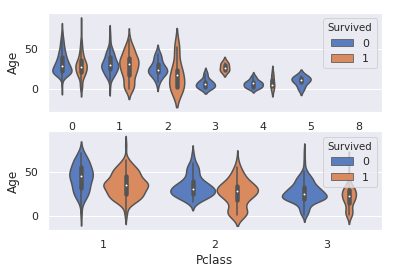

In [123]:
t_df_cp = train_df

sns.set()
fig, axes = plt.subplots(2,1)

#Let us look at a the violin plot of Survived vs. Age to see the distribution of data. 
#Scale helps you keep the distributions different with their widths and heights adjusted as per their counts
sns.violinplot(x="SibSp",y="Age", hue="Survived", data=t_df_cp, scale="count", palette="muted",ax=axes[0])
sns.violinplot(x="Pclass",y="Age", hue="Survived", data=t_df_cp, scale="count", palette="muted",ax=axes[1])

/home/ec2-user/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


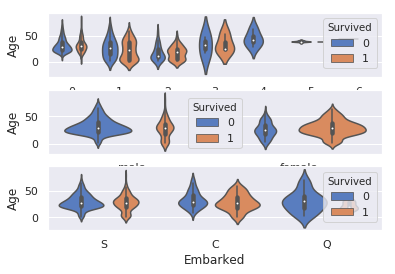

In [125]:
sns.set()
fig, axes2 = plt.subplots(3,1)
sns.violinplot(x="Parch",y="Age", hue="Survived", data=t_df_cp, scale="count", palette="muted",ax=axes2[0])
sns.violinplot(x="Sex",y="Age", hue="Survived", data=t_df_cp, scale="count", palette="muted",ax=axes2[1])
sns.violinplot(x="Embarked",y="Age", hue="Survived", data=t_df_cp, scale="count", palette="muted",ax=axes2[2])

#### 2. [Histograms](https://seaborn.pydata.org/generated/seaborn.distplot.html#seaborn.distplot), [Suplots](https://www.youtube.com/watch?v=Ql8QPcp8818)
Lets look at a simple set of histograms for idea on distribution of data

/home/ec2-user/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


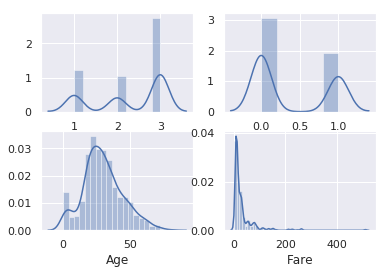

In [198]:
sns.set()
fig, ax = plt.subplots(2,2)

sns.distplot(t_df_cp["Pclass"],ax=ax[0,0])
sns.distplot(t_df_cp["Survived"],ax=ax[0,1])

t_df_age = t_df_cp["Age"].dropna()
sns.distplot(t_df_age,ax=ax[1,0])
sns.distplot(t_df_cp["Fare"],ax=ax[1,1])

#### 3. [Scatter Plots](https://seaborn.pydata.org/generated/seaborn.scatterplot.html), [Regression Plots](https://seaborn.pydata.org/generated/seaborn.regplot.html)

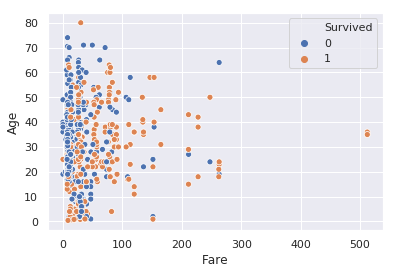

In [137]:
sns.scatterplot(x="Fare", y="Age", hue="Survived", data=t_df_cp)

We make the following key observation from the basic plots
1. SibSp >= 5 no one survived
2. Pclass = 3 Survival is low. Need to further explore this piece
3. Female - Survival is high, Male - Survival is low
4. Embarked - Q - Survival is low, C - Survival is High, S - Survival is Low (probably model can learn from this)
5. No specific observation from the scatter plot as there is no method to classify this data based on tickets and age

# 1. Prepare Data

### Correct the Training data
#### Step1 - Change the categorical variables to numerical values

In [138]:
# Lets use Pclass, Sex, Age, SibSp, Parch, Fare, Embarked

train_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].isnull().any()
#Lets predict the age from the Fare, Sex, Pclass, parch and SubSp and use it

selected_df = train_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'PassengerId', 'Survived']]

#Sex
selected_df['Sex'].replace('male',0, inplace=True)
selected_df['Sex'].replace('female',1, inplace=True)

#Embarked
selected_df['Embarked'].replace('S', 0, inplace=True)
selected_df['Embarked'].replace('C', 1, inplace=True)
selected_df['Embarked'].replace('Q', 2, inplace=True)

/home/ec2-user/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


### Impute for Predictors with missing values 
#### Step 2 - Use regression to predict the age missing values

In [139]:
# Select sepcific rows
age_select = selected_df.loc[selected_df['Age'].notnull(),['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

# Regression
lmod_age = lm.LinearRegression()
lmod_age.fit(age_select[['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']], age_select['Age'])

selected_df['predicted_age'] = lmod_age.predict(selected_df[['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']])

# Fill back the age correctly
#selected_df[['Age', 'predicted_age']].Age
#selected_df[['Age','predicted_age']].apply(lambda x: x)

import math

age = selected_df['Age']
pred_age = selected_df['predicted_age']

#selected_df['Age'] = np.where(math.isnan(age) is True, pred_age, age)

for ind, row in selected_df.iterrows():
    if math.isnan(row['Age']) is True:
        if(row['predicted_age'] > 0 ):
            selected_df['Age'][ind] = row['predicted_age']
        else:
            selected_df['Age'][ind] = 2

/home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2961: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.use

### Correct test data
#### 1. Handle categorical predictors

In [140]:
test_df['Sex'].replace('male',0, inplace=True)
test_df['Sex'].replace('female',1, inplace=True)

test_df[['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Age']].isnull().any()

Pclass    False
Sex       False
SibSp     False
Parch     False
Fare       True
Age        True
dtype: bool

In [8]:
test_df[test_df['Age'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
10,902,3,"Ilieff, Mr. Ylio",0,NaN,0,0,349220,7.8958,NaN,S
22,914,1,"Flegenheim, Mrs. Alfred (Antoinette)",1,NaN,0,0,PC 17598,31.6833,NaN,S
29,921,3,"Samaan, Mr. Elias",0,NaN,2,0,2662,21.6792,NaN,C
33,925,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",1,NaN,1,2,W./C. 6607,23.4500,NaN,S
36,928,3,"Roth, Miss. Sarah A",1,NaN,0,0,342712,8.0500,NaN,S
39,931,3,"Hee, Mr. Ling",0,NaN,0,0,1601,56.4958,NaN,S
41,933,1,"Franklin, Mr. Thomas Parham",0,NaN,0,0,113778,26.5500,D34,S
47,939,3,"Shaughnessy, Mr. Patrick",0,NaN,0,0,370374,7.7500,NaN,Q
54,946,2,"Mangiavacchi, Mr. Serafino Emilio",0,NaN,0,0,SC/A.3 2861,15.5792,NaN,C
58,950,3,"Davison, Mr. Thomas Henry",0,NaN,1,0,386525,16.1000,NaN,S


#### 2. Impute missing values

In [141]:
# There is only one value missing in Fare and we adjust that as per ticket prices as per observation
for ind, row in test_df.iterrows():
    if math.isnan(row['Fare']) is True:
        test_df['Fare'][ind] = 7.8958

# Setting the age
test_df['predicted_age'] = lmod_age.predict(test_df[['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']])

# Correct Age
for ind, row in test_df.iterrows():
    if math.isnan(row['Age']) is True:
        if(row['predicted_age'] > 0 ):
            test_df['Age'][ind] = row['predicted_age']
        else:
            test_df['Age'][ind] = 2

/home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


# 2. Setup Data

In [142]:
x_train = selected_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
y_train = selected_df['Survived']

# 3. Model Selection

## 3.1. Logistic Regression
Above Linear Regression model is only for representation sake. We need to use Logistic regression for this activity

In [11]:
lrmodel = lm.LogisticRegressionCV(cv=10, random_state=100)
lrmodel.fit(x_train, y_train)

litPredTrain = lrmodel.predict(x_train)
lrmodel.score(x_train, y_train)

0.8125701459034792

## 3.2. Random Forest Classification
Try a random forest classifier and see how it fits

In [12]:
#Running a random forest without tuning

rfmod = RandomForestClassifier()
rfmod.fit(x_train, y_train)

y_rtrainfit = rfmod.predict(x_train)
accuracy_score(y_train,y_rtrainfit)
# This accuracy for training set. So do not take it as its real performance.

0.9708193041526375

### Tune With GridSearchCV

In [13]:
params = [{'n_estimators': [10, 11, 12, 13, 14, 15, 20], 'max_depth': [2, 3, 4, 5, 6, 10,] }]
clf = GridSearchCV(RandomForestClassifier(), params, cv=10)
clf.fit(x_train, y_train)
print("Random forest classifier - Grid Search - Best params: ", clf.best_params_)
print("Random forest classifier - Grid Search - Best Score: ", clf.best_score_)

Random forest classifier - Grid Search - Best params:  {'max_depth': 6, 'n_estimators': 14}
Random forest classifier - Grid Search - Best Score:  0.835016835016835


## 3.3. Changing predictor set and checking with Random forest
### It seems to marginally improve if we drop fare

In [14]:
params = [{'n_estimators': [10, 11, 12, 13, 14, 15, 20], 'max_depth': [2, 3, 4, 5, 6, 10,] }]
clf = GridSearchCV(RandomForestClassifier(), params, cv=10)
clf.fit(x_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']], y_train)
print("Random forest classifier - Grid Search - Best params: ", clf.best_params_)
print("Random forest classifier - Grid Search - Best Score: ", clf.best_score_)

Random forest classifier - Grid Search - Best params:  {'max_depth': 6, 'n_estimators': 11}
Random forest classifier - Grid Search - Best Score:  0.8316498316498316


## 3.4. Support Vector Classification

In [15]:
svcmod = SVC()
svcmod.fit(x_train, y_train)

y_svctrainfit = svcmod.predict(x_train)
accuracy_score(y_train,y_svctrainfit)

0.9034792368125701

### Tune With GridSearchCV

In [16]:
# First scale the data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_sc = scaler.transform(x_train)

# Then tune the model
params = [{'C': [0.5, 1, 1.2], 'kernel': ['rbf', 'linear'] }]
clf = GridSearchCV(SVC(), params, cv=10)
#clf.fit(x_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']], y_train)
#print("Random forest classifier - Grid Search - Best params: ", clf.best_params_)
#print("Random forest classifier - Grid Search - Best Score: ", clf.best_score_)

## 3.5 XGBoost
[About](https://www.datacamp.com/community/tutorials/xgboost-in-python) XGBoost.
XGBoost is capable of handling missing data. But we have already handled it.

In [148]:
import xgboost as xgb

In [18]:
# Normal XGBoost
data_dmatrix = xgb.DMatrix(data=x_train, label=y_train)
xg_clf = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.9, learning_rate = 0.01, 
                           max_depth = 10, alpha = 10, n_estimators = 10)

xg_clf.fit(x_train, y_train)
preds = xg_clf.predict(x_train)
xg_clf.score(x_train, y_train)
accuracy_score(y_train,preds)

0.9326599326599326

In [19]:
# Then tune the model
params = [{'learning_rate': [0.01, 0.1, 0.5, 1], 'n_estimators': [10, 15, 20, 25], 'max_depth': [5, 10, 15, 20], 
           'colsample_bytree': [0.3, 0.6, 0.9], 'objective': ['reg:linear'], 'alpha': [10]}]
clf = GridSearchCV(xgb.XGBClassifier(), params, cv=10)
clf.fit(x_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']], y_train)
print("Random forest classifier - Grid Search - Best params: ", clf.best_params_)
print("Random forest classifier - Grid Search - Best Score: ", clf.best_score_)

Random forest classifier - Grid Search - Best params:  {'alpha': 10, 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 25, 'objective': 'reg:linear'}
Random forest classifier - Grid Search - Best Score:  0.8316498316498316


## 4. Summarizing Cross Validation Scores

1. Linear Regression : 81.26%
2. Random Forest (with Fare): 82.94%
   {'max_depth': 10, 'n_estimators': 14}
3. Random Forest (wo Fare): 83.05%
   {'max_depth': 5, 'n_estimators': 14}
4. SVC (wo Fare): 81.7%
   {'C': 1.2, 'kernel': 'rbf'}
5. XGBoost (with Fare): 83.6%
   {'alpha': 10, 'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 20, 'objective': 'reg:linear'}
6. XGBoost (wo Fare): 83.16%
   {'alpha': 10, 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 25, 'objective': 'reg:linear'}
   
From these scores we select (5) XGBoost with the chosen parameters - Probably the colsample_bytree value of 0.9 may have helped (leading to overfit). But let us see.

## 5. Predicting with Selected Model

In [20]:
# XGBoost
data_dmatrix = xgb.DMatrix(data=x_train, label=y_train)
xg_clf = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.9, learning_rate = 0.01, 
                           max_depth = 10, alpha = 10, n_estimators = 10)

xg_clf.fit(x_train, y_train)

preds = xg_clf.predict(test_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']])
test_df['Survived'] = preds

## 6. Write to file

In [21]:
finalResult = test_df[['PassengerId', 'Survived']]
finalResult.to_csv("result_final.csv", index=False)

### The above code gives you 77.03% accuracy when you upload to Kaggle.
### By just using the above data I assume that is the best you can achieve. Actually you can achieve the same number by using logistic regression as well. 

## 7. Feature Engineering
[Name based Feature Engineering](https://www.kaggle.com/cdeotte/titanic-using-name-only-0-81818)

Refer to that article to understand how someone created a new feature based on family name groupings. We use that information to build a new XGBoost model and see if it bumps up our score. It is not worth spending more time than this. So, I will just attempt this one feature engineering attempt here.

What these guys are doing is this
* If a surname-woman-child combination is found to be alive in training set then they are borrowing that same surname-woman-child combination information to the test set
* By default they are assuming that all women have survived. Which means they have only corrected for those cases where they definitely know the outcome from training set

This looks a bit like gaming rather than modeling. But let us see if it works.

In [210]:
import re

In [211]:
x_train['Name'] = train_df['Name']

In [212]:
p = re.compile('.*, (.*?)\.')
x_train['Title'] = x_train['Name'].apply(lambda x: p.match(x).group(1))

# Change the title now to either man / woman
x_train['Title'] = x_train['Title'].apply(lambda x: -1 if x in ["Capt","Don","Major","Col","Rev","Dr","Sir","Mr", "Jonkheer"] 
                                          else 1 if x in ["Dona","the Countess","Mme","Mlle","Ms","Miss","Lady","Mrs"]
                                                 else 0)

In [213]:
# Engineer "woman-child-groups"
p = re.compile('(.*?),.*')
x_train['Surname'] = x_train['Name'].apply(lambda x: p.match(x).group(1))

# Bucket people into three groups. All males go into no-group (-1)
x_train.Surname[x_train.Title==-1] = -1

# Check the bucket sizes for others
surnamefreq = x_train.groupby(['Surname']).size()
x_train['SurnameFreq'] = x_train['Surname'].apply(lambda x: surnamefreq[x])

# If the family group size is just one then call that as no-group (-1)
x_train['Surname'][x_train['SurnameFreq'] <= 1] = -1

# Update frequencies one final time
surnamefreq = x_train.groupby(['Surname']).size()
x_train['SurnameFreq'] = x_train['Surname'].apply(lambda x: surnamefreq[x])

# Now all the remaining women and children group has to be marked as a single group because mother and child fates
# identified to be intertwined (in that shared link)

# Now change Surnames and Titles into numeric data to have them be handled by XGBoost
#x_train['Surname'][x_train['Surname'] != -1] = 1
#x_train['SurnameClass'] = x_train['Surname'].apply(lambda x: int(x))

# Now write the survival rate for the women-child-family name combinations
x_train['Survived'] = y_train
name_survival = x_train.groupby(['Surname','Survived']).size()

for ind, row in x_train.iterrows():
    surived_c = 0
    not_survived_c = 0
    
    if((row['Surname'],1) in name_survival.index):
        survived_c = name_survival[row['Surname'],1]
    else:
        survived_c = 0
    
    if((row['Surname'],0) in name_survival.index):
        not_survived_c = name_survival[row['Surname'],0]
    else:
        not_survived_c = 0
        
    if(survived_c + not_survived_c > 0):
        x_train.loc[ind,'SurnameSurvival'] = survived_c/(survived_c + not_survived_c)
    else:
        x_train.loc[ind,'SurnameSurvival'] = 0

/home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [214]:
# Now check XGBoost with the new engineered parameters on Surname and title
# Then tune the model
params = [{'learning_rate': [0.01, 0.1, 0.5, 1], 'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15, 20], 
           'colsample_bytree': [0.3, 0.6, 0.9], 'objective': ['reg:linear'], 'alpha': [10]}]
clf = GridSearchCV(xgb.XGBClassifier(), params, cv=10)
clf.fit(x_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'SurnameSurvival']], y_train)
print("Random forest classifier - Grid Search - Best params: ", clf.best_params_)
print("Random forest classifier - Grid Search - Best Score: ", clf.best_score_)

Random forest classifier - Grid Search - Best params:  {'alpha': 10, 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'objective': 'reg:linear'}
Random forest classifier - Grid Search - Best Score:  0.8608305274971941


#### We see that there is a slight bump in the cross validated score to 86.08%. Let us see if it really works.
##### Engineering the features for Test set now

In [215]:
p = re.compile('.*, (.*?)\.')
test_df['Title'] = test_df['Name'].apply(lambda x: p.match(x).group(1))

# Change the title now to either man / woman
test_df['Title'] = test_df['Title'].apply(lambda x: -1 if x in ["Capt","Don","Major","Col","Rev","Dr","Sir","Mr", "Jonkheer"] 
                                          else 1 if x in ["Dona","the Countess","Mme","Mlle","Ms","Miss","Lady","Mrs"]
                                                 else 0)

# Engineer "woman-child-groups"
p = re.compile('(.*?),.*')
test_df['Surname'] = test_df['Name'].apply(lambda x: p.match(x).group(1))

# Bucket people into three groups. All males go into no-group (-1)
test_df.Surname[test_df.Title==-1] = -1

# Check the bucket sizes for others
surnamefreq = test_df.groupby(['Surname']).size()
test_df['SurnameFreq'] = test_df['Surname'].apply(lambda x: surnamefreq[x])

# If the family group size is just one then call that as no-group (-1)
test_df['Surname'][test_df['SurnameFreq'] <= 1] = -1

# Now all the remaining women and children group has to be marked as a single group because mother and child fates
# identified to be intertwined (in that shared link)

# Here borrow from training set
test_df['SurnameSurvival'] = 0

#test_df['Surname'].unique()

for ind, row in test_df.iterrows():
    if(row['Surname'] in x_train['Surname'].unique()):
        test_df.loc[ind,'SurnameSurvival'] = x_train['SurnameSurvival'][x_train['Surname'] == row['Surname']].iloc[0]

/home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [28]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,predicted_age,Survived,Title,Surname,SurnameFreq,SurnameSurvival
0,892,3,"Kelly, Mr. James",0,34.500000,0,0,330911,7.8292,NaN,Q,28.296487,0,-1,-1,245,0.34713
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.000000,1,0,363272,7.0000,NaN,S,21.265596,0,1,-1,1,0.34713
2,894,2,"Myles, Mr. Thomas Francis",0,62.000000,0,0,240276,9.6875,NaN,Q,35.274568,0,-1,-1,245,0.34713
3,895,3,"Wirz, Mr. Albert",0,27.000000,0,0,315154,8.6625,NaN,S,28.281555,0,-1,-1,245,0.34713
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.000000,1,1,3101298,12.2875,NaN,S,20.398986,1,1,-1,1,0.34713
5,897,3,"Svensson, Mr. Johan Cervin",0,14.000000,0,0,7538,9.2250,NaN,S,28.271476,0,-1,-1,245,0.34713
6,898,3,"Connolly, Miss. Kate",1,30.000000,0,0,330972,7.6292,NaN,Q,25.057477,0,1,-1,1,0.34713
7,899,2,"Caldwell, Mr. Albert Francis",0,26.000000,1,1,248738,29.0000,NaN,S,30.353489,0,-1,-1,245,0.34713
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",1,18.000000,0,0,2657,7.2292,NaN,C,25.064645,1,1,-1,1,0.34713
9,901,3,"Davies, Mr. John Samuel",0,21.000000,2,0,A/4 48871,24.1500,NaN,S,20.397725,0,-1,-1,245,0.34713


## 8. Create an upgraded XGBoost Model

In [152]:
# XGBoost
# Set this as per the tuning from GridSearch
# {'alpha': 10, 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 
#  'n_estimators': 50, 'objective': 'reg:linear'}
data_dmatrix = xgb.DMatrix(data=x_train[['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'SurnameSurvival']], label=y_train)
xg_clf = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.9, learning_rate = 0.1, 
                           max_depth = 5, alpha = 10, n_estimators = 50)

xg_clf.fit(x_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'SurnameSurvival']], y_train)

preds = xg_clf.predict(test_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'SurnameSurvival']])
test_df['Survived'] = preds

#### Check if manual correction is required.

In [153]:
for ind, row in test_df.iterrows():
    if(row['Surname'] in x_train['Surname'].unique()):
        if(x_train['SurnameSurvival'][x_train['Surname'] == row['Surname']].iloc[0] in [0,1]):
            print(row['Survived'], x_train['SurnameSurvival'][x_train['Surname'] == row['Surname']].iloc[0])

1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
0 0.0
1 1.0
1 1.0
0 0.0
0 0.0


In [165]:
test_df[test_df["SibSp"] >= 5]["Survived"] = 0
test_df[test_df["Parch"] >= 4]["Survived"] = 0

/home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ec2-user/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### The feature engineering model assumes that a woman by default lives unless there is a strong contradictory evidence. So making that correction here.

In [31]:
for ind, row in test_df.iterrows():
    if(row['Title'] == 1 and row['Survived'] == 0 and row['SurnameSurvival'] != 0):
        test_df.loc[ind,'Survived'] = 1

## 9. Write to file

In [32]:
finalResult = test_df[['PassengerId', 'Survived']]
finalResult.to_csv("result_final_fe.csv", index=False)

## 10. Testing Logistic Regression to see if it does any better.
### Interestingly LR gives better prediction than XGBoost in Kaggle for this correction

In [217]:
lrmodel = lm.LogisticRegressionCV(cv=10, random_state=100)
lrmodel.fit(x_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'SurnameSurvival']], y_train)

litPredTrain = lrmodel.predict(x_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'SurnameSurvival']])
lrmodel.score(x_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'SurnameSurvival']], y_train)

0.8451178451178452

In [219]:
preds = lrmodel.predict(test_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'SurnameSurvival']])
test_df['Survived'] = preds

#### Check to see if our prediction is consistent with SurnameSurvival 

In [220]:
for ind, row in test_df.iterrows():
    if(row['Surname'] in x_train['Surname'].unique()):
        if(x_train['SurnameSurvival'][x_train['Surname'] == row['Surname']].iloc[0] in [0,1]):
            print(row['Survived'], x_train['SurnameSurvival'][x_train['Surname'] == row['Surname']].iloc[0])
            
            
for ind, row in test_df.iterrows():
    if(row['Surname'] == -1 and row['Title'] == 0):
        print(row['Name'],row['Survived'], x_train['SurnameSurvival'][x_train['Surname'] == row['Surname']].iloc[0])

1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
1 1.0
0 0.0
1 1.0
1 1.0
0 0.0
0 0.0
Olsen, Master. Artur Karl 0 0.3471295060080107
Rice, Master. Albert 0 0.3471295060080107
Boulos, Master. Akar 0 0.3471295060080107
Drew, Master. Marshall Brines 0 0.3471295060080107
Spedden, Master. Robert Douglas 1 0.3471295060080107
Danbom, Master. Gilbert Sigvard Emanuel 0 0.3471295060080107
Aks, Master. Philip Frank 0 0.3471295060080107
Betros, Master. Seman 0 0.3471295060080107
Palsson, Master. Paul Folke 0 0.3471295060080107
Abbott, Master. Eugene Joseph 0 0.3471295060080107
Peter, Master. Michael J 0 0.3471295060080107


#### The feature engineering model assumes that a woman by default lives unless there is a strong contradictory evidence. So making that correction here.

In [221]:
# Females
for ind, row in test_df.iterrows():
    if(row['Title'] == 1 and row['Survived'] == 0 and row['SurnameSurvival'] != 0):
        test_df.loc[ind,'Survived'] = 1
    if(row['Title'] == -1 and row['Survived'] == 1 and row['Sex'] == 0):
        test_df.loc[ind,'Survived'] = 0

In [223]:
finalResult = test_df[['PassengerId', 'Survived']]
finalResult.to_csv("result_final_lr_2.csv", index=False)

## I am stopping regular models here. This correction gives us 77.99% accuracy with the test set and places us somewhere in the middle of the scores. Which is fine. It is a good practice till here.